In [126]:
!pip install wfdb
import wfdb
import pandas as pd
from wfdb import processing
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

In [126]:
from google.colab import drive
drive.mount('/content/drive')

# A dataset for CNN-based QRS detection

In the previous exercise I showed how to detect a QRS peak by traditional algorithms. Today, with the most recent computing capabilities, it is possible to obtain a better accuracy with the power of Deep Learning. Indeed, it is possible to train a CNN to detect QRS peaks. The purpose of this notebook is to build a dataset to feed such a CNN. 

As an input dataset we are taking the whole patients database and we define the sampling intervals for the ECGs. In this case the interval will be [0, 1.5s]

In [2]:
path = "/content/drive/MyDrive/ECG/ptb-diagnostic-ecg-database-1.0.0/"
t_0 = 0
t_fin = 1500

with open(path + '/RECORDS') as f:
    files = f.read().splitlines() 
    
records = []
patients = []

for file in files:
    records.append(wfdb.rdrecord(path + "/"+ file, sampfrom=t_0, sampto=t_fin)) # The units in samp are miliseconds, we sample 1.5 seconds
    patients.append(file.split('/')[0])

The preprocessing of the signals are done in two steps:
- Baseline removal: This step is needed to remove external signals from the ECG (such as breathing) so the CNN does not learn them as signal.
- Signal normalization: This step is needed to guarantee that all the features are learned in the same scale.

In [3]:
def remove_baseline(record, channel):
    """ Removes the baseline from the ECG by applying a LOWESS smoother """
    
    signal_0 = record.p_signal[:, channel]
    x = np.arange(len(signal_0))
    baseline = sm.nonparametric.lowess(signal_0, x, frac = 0.05) 
    signal_b = signal_0-baseline[:, 1]
    return signal_b

def normalize_ECG(signal):
    """ Normalizes the signal
    
    The normalized signal is centered in the interval [-1, 1]
    
    """
    
    norm = max(signal.max(), abs(signal.min()))
    return signal/norm

def parse_coms(record):
    """ Formats the comments of the record as a python dictionary """
    
    head_info = {}
    for item in record.comments:
        elem = item.split(':')
        head_info[elem[0]] = elem[1].lstrip()
    
    keys =  list(head_info.keys())
    ii_diag = [i for i, x in enumerate(keys) if x == "Diagnose"][0]
    ii_hemo = [i for i, x in enumerate(keys) if x == "Hemodynamics"][0]
    ii_ther = [i for i, x in enumerate(keys) if x == "Therapy"][0]

    keys_diag = [x for i, x in enumerate(keys) if ii_diag < i < ii_hemo]
    keys_hemo = [x for i, x in enumerate(keys) if ii_hemo < i < ii_ther]
    keys_ther = [x for i, x in enumerate(keys) if ii_ther < i]
    
    header_all = {"age":head_info["age"], 
                  "sex":head_info["sex"], 
                  "ECG date":head_info["ECG date"], 
                  "Diagnose":{}, 
                  "Hemodynamics":{}, 
                  "Therapy":{}}

    for key in keys_diag:
        header_all['Diagnose'][key] = head_info[key]
    for key in keys_hemo:
        header_all['Hemodynamics'][key] = head_info[key]
    for key in keys_ther:
        header_all['Therapy'][key] = head_info[key]
        
    return header_all

For each patient in the sample, the following information is stored in lists:
- The preprocessed ECG signal (de-baselined, normalized) corresponding to the channel 1 (it can be any other channel)
- The reason for their admission

Then the result is converted to a pandas DataFrame:

In [4]:
signals_post = []
reasons = []
channel = 1

for record in records:
    signals_post.append(normalize_ECG(remove_baseline(record, channel)))
    reasons.append(parse_coms(record)['Diagnose']['Reason for admission'])
    
df = pd.DataFrame({'Patient': patients, 'Motive': reasons,'Signal': signals_post})
df.sample(5)

,Patient,Motive,Signal
80,patient028,Myocardial infarction,"[-0.09881167359340214, -0.07469287663075362, -..."
442,patient210,Hypertrophy,"[-0.0032695056582057063, -0.001459884981811797..."
534,patient284,Healthy control,"[-0.0010454580068732563, -0.002926246597146178..."
13,patient006,Myocardial infarction,"[0.0417332366062682, 0.0210034659442062, -0.04..."
434,patient203,Bundle branch block,"[0.010788768371254689, 0.007412831489172913, 0..."


In [5]:
### Proceso:
## Quitar baseline  HECHO
## Normalizar HECHO
## Determinar máximo HECHO
## Tomar puntos a un lado y al otro HECHO
## Segmentar dataset HECHO


## Determinar dataset total (un canal o varios?) HECHO - De momento, un canal
## Dividir en train test dev
## Adaptar al input de la CNN
## Entrenar
## Matriz de confusión

## OPTION 1: DETERMINAR QRS A TRAVES DE RED NEURONAL -> SEGUIR PAPER
## OPTION 2: CLASIFICAR EN SANO, NO SANO -> TAL VEZ REQUIERE OTRA ESTRUCTURA - MUY COMPLICADO, EXPLICAR AL FINAL

The admission reasons are the following, with the number of ECGs registered for each corresponding case:

In [6]:
df.Motive.value_counts()

Myocardial infarction     368
Healthy control            80
n/a                        27
Cardiomyopathy             17
Bundle branch block        17
Dysrhythmia                16
Hypertrophy                 7
Valvular heart disease      6
Myocarditis                 4
Stable angina               2
Heart failure (NYHA 2)      1
Heart failure (NYHA 3)      1
Heart failure (NYHA 4)      1
Palpitation                 1
Unstable angina             1
Name: Motive, dtype: int64

After that, a quick eye check on every ECG, motive by motive, is performed to remove problematic signals. A signal is accepted if:
- A full QRS complex is recorded and identified
- There is no missing data inside the QRS complex (easily seen by fully horizontal lines)

For the moment I'm holding these criteria, knowing that for a deeper analysis a different criterion may be needed for each motive. This one would be an example of an accepted ECG:

/tmp/ipykernel_39788/1425451571.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df.Motive == 'Healthy control'][df.Patient == 'patient284'].iloc[0].Signal)


Text(0, 0.5, 'Amplitude (norm)')

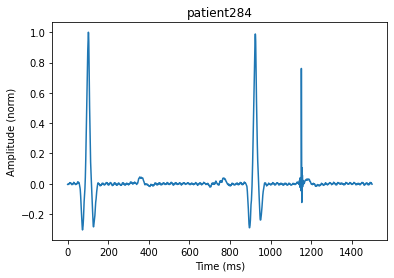

In [30]:
plt.plot(df[df.Motive == 'Healthy control'][df.Patient == 'patient284'].iloc[0].Signal)
plt.title('patient284')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (norm)')

And this one would be an example of an rejected ECG, with an incomplete pulse followed by a QRS complex with missing data:

/tmp/ipykernel_39788/1840711652.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df[df.Motive == 'Healthy control'][df.Patient == 'patient255'].iloc[0].Signal)


Text(0, 0.5, 'Amplitude (norm)')

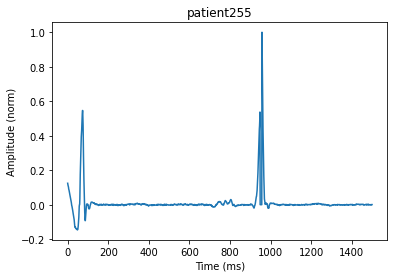

In [31]:
plt.plot(df[df.Motive == 'Healthy control'][df.Patient == 'patient255'].iloc[0].Signal)
plt.title('patient255')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (norm)')

In case of not having enough data to feed a CNN, we could always increase the sampling window of the ECG signal and extract a complete QRS complex.

After a full eye check of the entire dataset, I am going to drop the following patients:

In [114]:
todrop_patients= {'Healthy control': [150, 165, 174, 236, 245, 255, 277], 
                  'Myocardial infarction': [7, 14, 18, 23, 44, 45, 59, 65, 67, 72, 73, 75, 79, 81, 86, 93, 99, 100, 183, 197],
                  'n/a': [136, 186, 194, 285],
                  'Cardiomyopathy': [127, 215],
                  'Bundle branch block': [219, 225],
                  'Dysrhythmia': [],
                  'Hypertrophy': [212, 227],
                  'Valvular heart disease': [188]}

patients_todrop = ['patient'+str(item).zfill(3) for item in sum(list(todrop_patients.values()), [])]

df_ECG = df[~df.Patient.isin(patients_todrop)].copy()

print('Full dataset shape: '+ str(np.shape(df.Signal)))
print('Processed dataset shape: ' + str(np.shape(df_ECG.Signal)))

df_ECG.sample(5)

Full dataset shape: (549,)
Processed dataset shape: (458,)


,Patient,Motive,Signal
70,patient024,Myocardial infarction,"[0.014535385815270124, 0.021571847820201332, 0..."
100,patient033,Myocardial infarction,"[0.07243986002436745, 0.1058289187919632, 0.12..."
366,patient153,Dysrhythmia,"[0.21677340613253945, 0.17201591472643982, 0.1..."
433,patient202,Bundle branch block,"[0.054180225828668445, 0.048720155937411136, 0..."
122,patient040,Myocardial infarction,"[-0.0116733904596987, -0.016314514341614888, 0..."


### Labelling the data

I will address the QRS detection as a supervised classification problem. It will imply a labelling process, where we tell the neural network what a QRS complex is, and what is not. In this case, I will:
- Extract a pulse for every signal by a rudimentary detection of the maximum of the signal and center the pulse in the R peak,
- Take points at each side so we can include the Q and S peaks as well as the pulse baseline
- Label those points as 1 (affirmative detection of a QRS signal)
- Label the rest at 0 (negative detection of a QRS signal)

In literature, Sarlija, M., Jurisic F., Popovic S. (2017) used a +-40 ms window for QRS labelling. Here, as a window I will use +-120 ms for the whole crop and +-60 ms from the R peak for the QRS labelling.

These values can be tuned in case the false positive rate is high after the training process.

In [118]:
def crop_sig(signal, y, from_v, to_v):
    """ Crops the signal between two given intervals 
    
    Takes a window of the signal between two points and centered in the maximum value 
    
    Input: 
        signal: list or array of floats
        x:  list or array of floats 
        from_v: int
        to_v: int
        
    Returns:
        [signal list, y list]
    """
    locmax = int(np.where(signal == signal.max())[0])
    return [signal[locmax-from_v: locmax+from_v], y[locmax-from_v: locmax+from_v]]

def QRS_label(signal, from_v, to_v):
    """ Labels the signal between two points as 1 and the rest of the signal as 0
    
    Input: 
        signal: list or array of floats
        from_v: int
        to_v: int
        
    Returns:
        y: list of ints
    """
    locmax = int(np.where(signal == signal.max())[0])
    y = np.zeros(len(signal))
    y[locmax-from_v: locmax+from_v] = 1
    return y

df_ECG['Label_Signal'] = df_ECG.Signal.apply(lambda x: QRS_label(x, 60, 60))
df_ECG['Signal_crop'] = df_ECG.apply(lambda x: crop_sig(x.Signal, x.Label_Signal, 120, 120), axis=1).apply(lambda x: x[0])
df_ECG['Label_crop'] = df_ECG.apply(lambda x: crop_sig(x.Signal, x.Label_Signal, 120, 120), axis=1).apply(lambda x: x[1])

df_ECG.sample(5)

,Patient,Motive,Signal,Label_Signal,Signal_crop,Label_crop
524,patient278,n/a,"[0.005323979795880256, 0.013385883146967786, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0948386718901324, -0.11960354270284962, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
94,patient032,Myocardial infarction,"[0.012402122948163327, -0.011881760185567473, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0033699829043630086, 0.02654318055000145, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
178,patient061,Myocardial infarction,"[-0.007569195931284191, 0.011519336764259798, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.03431507652375266, 0.024502576795981498, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
101,patient034,Myocardial infarction,"[0.012992315793735124, 0.0023525611993251826, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0432756312580879, 0.039418637738008445, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
162,patient051,Myocardial infarction,"[-0.02467993893451024, 0.012908762159288871, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0718306176520737, 0.08146847312897432, 0.08...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


As an example, this would be one of the entries of the dataset:

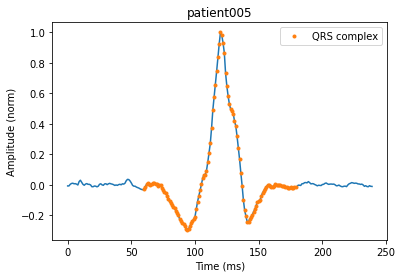

In [123]:
sig_example = df_ECG.iloc[8]

plt.plot(df_ECG.Signal_crop.iloc[8])
plt.plot(np.where(sig_example.Label_crop!=0)[0], 
         sig_example.Label_crop[np.where(sig_example.Label_crop!=0)]*sig_example.Signal_crop[np.where(sig_example.Label_crop!=0)], 
         '.', label = 'QRS complex')
plt.title(df_ECG.Patient.iloc[8])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (norm)')
plt.legend()

The final dataset now has the following structure:

- 458 signals, each of them with a length of 240 points
- 458 label vectors, each of them with a length of 240 points

A proposal for a 1D-CNN would be the structure implemented in Sarlija, M., Jurisic F., Popovic S. (2017):

In [125]:
input_shape = (240, 1) 

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(32, 5, strides = 1, activation='relu'),
    layers.Dropout(0.5),
    layers.MaxPool1D(pool_size=3, strides=2, padding='valid'),
    layers.Conv1D(32, 5, strides=1, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Softmax()
])
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 236, 32)           192       
                                                                 
 dropout_8 (Dropout)         (None, 236, 32)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 117, 32)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 113, 32)           5152      
                                                                 
 dropout_9 (Dropout)         (None, 113, 32)           0         
                                                                 
 dense_4 (Dense)             (None, 113, 32)           1056      
                                                      

The following steps would be the splitting of the dataset in train, validation, test:
- Train (80%)
- Validation (10%)
- Test (10%)

In this case, it is important that all the motive classes are balanced within the three splits. That is, that there is not an undersampling of specific clases (lack of 'Healthy control', for example). In case these data would be insuficient, it is possible to increase the data sample by taking longer sampling windows and extracting several pulses from them.

Finally, the network would be ready to be trained after arranging the data in the right input format.